<a href="https://colab.research.google.com/github/WaithiraHawi/Python/blob/main/loan_default.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# Loan Default Analysis + Customer Segmentation & Risk Profiling
import pandas as pd, numpy as np, joblib, os
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt, seaborn as sns

# ======= CONFIG =======
CSV_PATH = "/content/Loan_default.csv"
SILHOUETTE_SAMPLE = 50000   # set to len(X) to run silhouette on full data (slower)
K_RANGE = range(2, 8)       # try k = 2..7
# =======================

# Loading dataset
df = pd.read_csv(CSV_PATH)
print("Loaded:", df.shape)
print("Columns:", df.columns.tolist())

Loaded: (255347, 18)
Columns: ['LoanID', 'Age', 'Income', 'LoanAmount', 'CreditScore', 'MonthsEmployed', 'NumCreditLines', 'InterestRate', 'LoanTerm', 'DTIRatio', 'Education', 'EmploymentType', 'MaritalStatus', 'HasMortgage', 'HasDependents', 'LoanPurpose', 'HasCoSigner', 'Default']


In [6]:
# Auto-detect target column
candidates = [c for c in df.columns if 'default' in c.lower() or 'is_default' in c.lower() or 'loan_status' in c.lower()]
if candidates:
    target_col = candidates[0]
else:
    # fallback - any strictly binary column (2 unique values)
    binaries = [c for c in df.columns if df[c].nunique(dropna=True) == 2]
    if binaries:
        target_col = binaries[0]
    else:
        raise ValueError("No obvious target column found. Please set target_col manually.")
print("Detected target column:", target_col)
print(df[target_col].value_counts(dropna=False))

Detected target column: Default
Default
0    225694
1     29653
Name: count, dtype: int64


In [7]:
# Dropping ID-like columns (unique per row or name contains 'id')
id_by_name = [c for c in df.columns if 'id' in c.lower()]
id_by_unique = [c for c in df.columns if df[c].nunique(dropna=True) == len(df)]
id_cols = sorted(set(id_by_name + id_by_unique))
# never drop target if misdetected
id_cols = [c for c in id_cols if c != target_col]
print("Dropping ID-like columns:", id_cols)
df = df.drop(columns=id_cols, errors='ignore')

Dropping ID-like columns: ['LoanID']


In [8]:
# Filling missing values (numeric: median, categorical: mode)
for col in df.columns:
    if col == target_col:
        continue
    if df[col].dtype.kind in 'biufc':  # numeric
        df[col].fillna(df[col].median(), inplace=True)
    else:
        mode = df[col].mode()
        df[col].fillna(mode.iloc[0] if not mode.empty else "", inplace=True)

/tmp/ipython-input-1509549403.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
/tmp/ipython-input-1509549403.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try usin

In [9]:
# Encoding categoricals (excluding target)
cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
cat_cols = [c for c in cat_cols if c != target_col]
encoders = {}
for c in cat_cols:
    le = LabelEncoder()
    df[c] = le.fit_transform(df[c].astype(str))
    encoders[c] = le

# Making sure target is numeric 0/1
if df[target_col].dtype == 'object' or df[target_col].dtype.name == 'category':
    # common mappings
    df[target_col] = df[target_col].astype(str).str.lower().map({
        'no':0,'n':0,'0':0,'false':0,'f':0,
        'yes':1,'y':1,'1':1,'true':1,'t':1
    }).fillna(df[target_col])
df[target_col] = df[target_col].astype(int)

In [10]:
# Preparing X, y
features = [c for c in df.columns if c != target_col]
X = df[features].copy()
y = df[target_col].copy()
print("Features:", len(features))

Features: 16


In [12]:
# Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
joblib.dump(scaler, "/content/Loan_default.csv")

['/content/Loan_default.csv']

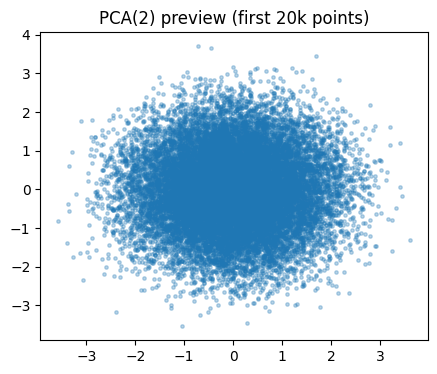

In [13]:
# PCA quick preview
pca = PCA(n_components=2, random_state=42)
try:
    X_pca2 = pca.fit_transform(X_scaled)
    plt.figure(figsize=(5,4))
    plt.scatter(X_pca2[:20000,0], X_pca2[:20000,1], s=6, alpha=0.3)  # plot up to 20k for speed
    plt.title("PCA(2) preview (first 20k points)")
    plt.show()
except Exception as e:
    print("PCA/plot skipped due to:", e)

In [14]:
# Silhouette search on a sample (faster)
n = len(X_scaled)
sample_n = min(SILHOUETTE_SAMPLE, n)
rng = np.random.RandomState(42)
sample_idx = rng.choice(n, sample_n, replace=False)
X_sample = X_scaled[sample_idx]

sil_scores = {}
for k in K_RANGE:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_sample)
    sil = silhouette_score(X_sample, labels)
    sil_scores[k] = sil
    print(f"k={k}: silhouette={sil:.4f}")

best_k = max(sil_scores, key=sil_scores.get)
print("Best k:", best_k)

k=2: silhouette=0.0634
k=3: silhouette=0.0506
k=4: silhouette=0.0671
k=5: silhouette=0.0520
k=6: silhouette=0.0489
k=7: silhouette=0.0477
Best k: 4


In [16]:
# Fitting KMeans on the sample
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=20)
kmeans.fit(X_sample)
clusters = kmeans.predict(X_scaled)
df['cluster'] = clusters

In [17]:
# Cluster sizes & default rates
cluster_sizes = df['cluster'].value_counts().sort_index()
print("Cluster sizes:\n", cluster_sizes.to_dict())
cluster_rate = df.groupby('cluster')[target_col].agg(['count','mean']).rename(columns={'mean':'default_rate'})
cluster_rate['default_rate_pct'] = (cluster_rate['default_rate']*100).round(2)
print(cluster_rate)

Cluster sizes:
 {0: 63877, 1: 63805, 2: 63800, 3: 63865}
         count  default_rate  default_rate_pct
cluster                                       
0        63877      0.097923              9.79
1        63805      0.134786             13.48
2        63800      0.119702             11.97
3        63865      0.112127             11.21


In [18]:
# Risk labels by tertiles of cluster default rate
r = cluster_rate['default_rate']
q1 = r.quantile(1/3); q2 = r.quantile(2/3)
risk_map = {}
for c,v in r.items():
    if v <= q1:
        risk_map[c] = 'Low'
    elif v <= q2:
        risk_map[c] = 'Medium'
    else:
        risk_map[c] = 'High'
df['risk_label'] = df['cluster'].map(risk_map)

In [19]:
# Quick RF baseline
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
prob = rf.predict_proba(X_test)[:,1]
print("RF ROC-AUC:", roc_auc_score(y_test, prob))

RF ROC-AUC: 0.7344217056746903


In [20]:
# Compact cluster profile for inspection
profile = df.groupby('cluster').agg(cluster_count=('cluster','count'),
                                    default_rate=(target_col,'mean')).reset_index()
profile['risk_label'] = profile['cluster'].map(risk_map)
print("\nCluster profile:\n", profile)


Cluster profile:
    cluster  cluster_count  default_rate risk_label
0        0          63877      0.097923        Low
1        1          63805      0.134786       High
2        2          63800      0.119702     Medium
3        3          63865      0.112127        Low
